In [1]:
import numpy as np
import os
from astropy.io import fits
from astropy.stats import LombScargle
from photutils import aperture_photometry as photometry
from photutils import CircularAperture as circle
from photutils import CircularAnnulus as annulus
from photutils import RectangularAperture as rectangle
from photutils import ApertureMask as mask
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
np.set_printoptions(threshold=np.nan)

# Any comment that contains the word "specify" requires you to enter a name, value, or variable for that line of code. 
# The remaining lines of code will perform calculations and display plots automatically.

                                                Opening Full Image Files

In [2]:
directory = '/Users/chris/Documents/KELT/Full Images' # **specify path of directory that contains full image fits files**
file_names = '/Users/chris/Documents/KELT/Y Oph-Image Cutouts/Image_%04d.txt' # **specify path of file names for image cutouts**

files = len(os.listdir(directory)) # gives number of files in directory
sort_files = sorted(os.listdir(directory)) # sort directory in alphanumeric order
load_files = [os.path.join(directory, sort_files[i]) for i in range(0,files)] # create file path names for full image files
open_files = [fits.open(load_files[i]) for i in range(0,files)] # open full image files

                                                Creating Image Cutouts

In [ ]:
start = 1 # **specify first file to get image data from**
stop = 600 # **specify last file to get image data from**
image_data = [open_files[i][1].data for i in range(start,stop)] # get image data for files in specified range

In [ ]:
cutout = [image_data[i][541:641, 801:901] for i in range(0,stop-start+1)] # **specify y and x pixel range for cutouts**
file_range = [file_names % i for i in range(start,stop+1)] # create file path names for cutouts in specified range
save_files = [np.savetxt(file_range[i], cutout[i]) for i in range(0,stop-start+1)] # save cutouts as text files

                                        Producing a Light Curve and Phase Curve

In [3]:
all_files = [file_names % i for i in range(1,files+1)] # create file path names for all cutouts
data = [np.loadtxt(all_files[i], dtype='float') for i in range(0,files)] # get data from image cutouts

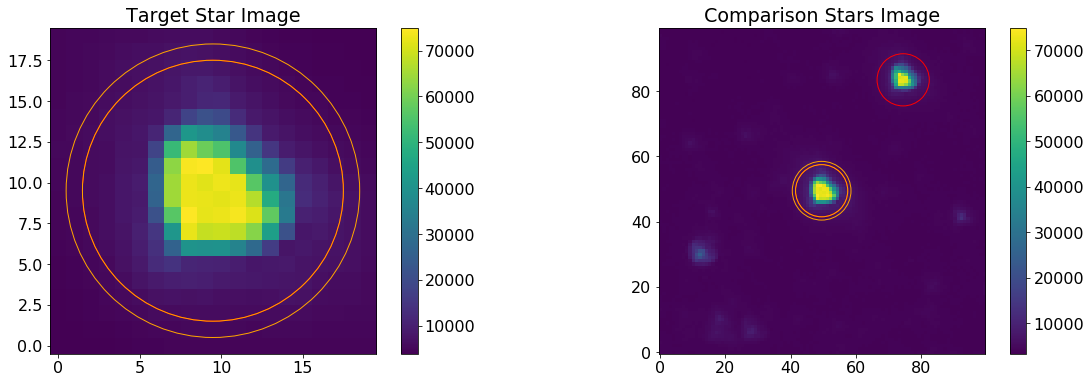

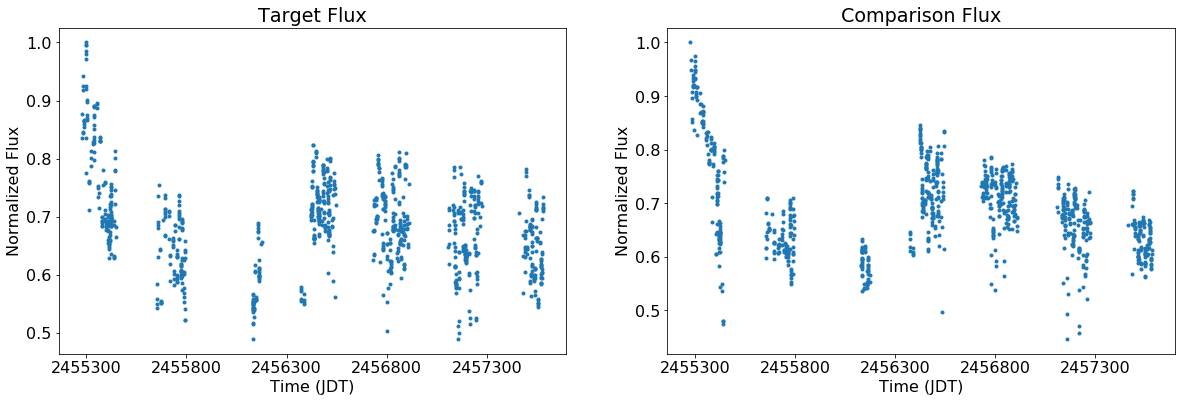

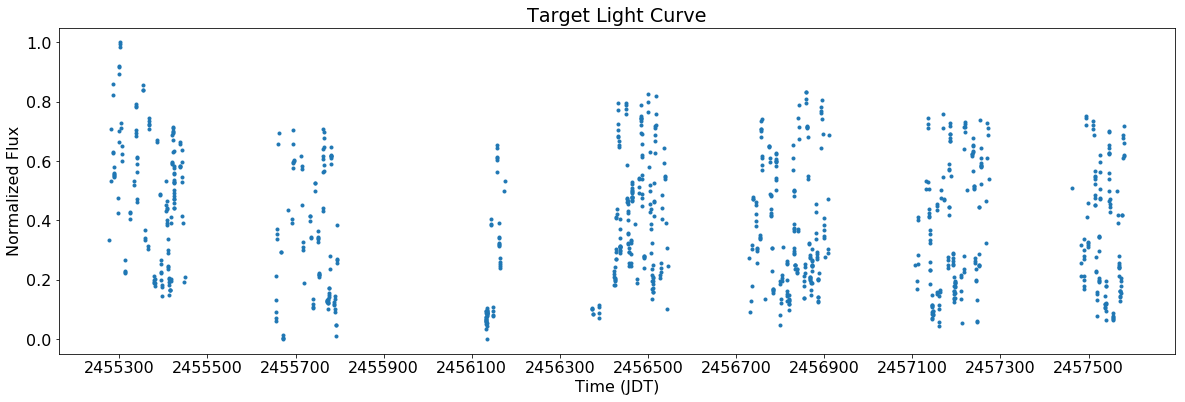

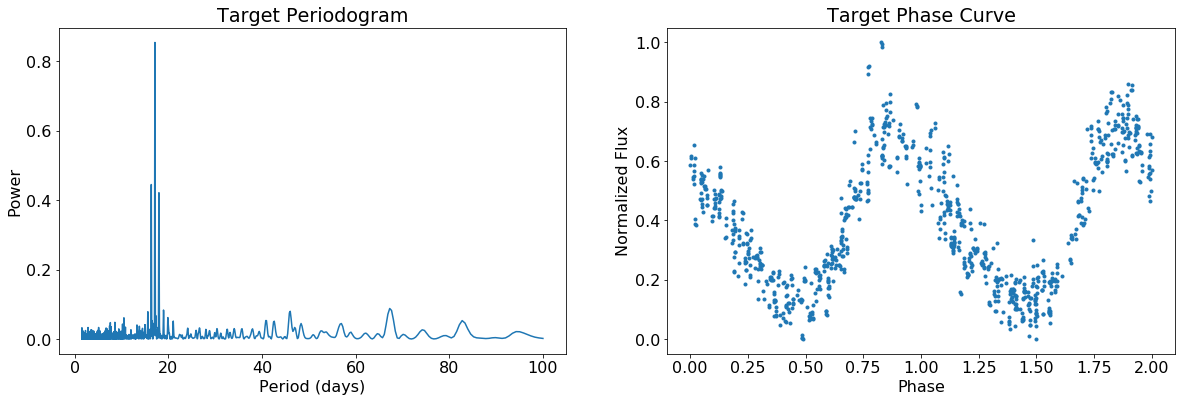

best period for range 1.5 to 100 days = 17.129830529694278 days
power value for best period =  0.854787775712425


In [4]:

# The following data for this star is given in the VizieR database
# name: Y Oph, period: 17.125 days, RA and dec: (17:52:38.7000, -06:08:36.888), magnitude range: (5.870, 6.340)


file = 1 # **specify target file number to display target image**

size = 20 # **specify x by x pixel size of target image**
center = len(data[file-1])/2 # calculate center location of target image
target = data[file-1][int(center-size/2):int(center+size/2),int(center-size/2):int(center+size/2)] # create array of target image data values for specified file

x_a = 9.5 # **specify x coordinate of target aperture center** 
y_a = 9.5 # **specify y coordinate of target aperture center** 
r = 8 # **specify radius of target aperture**

x_b = 9.5 # **specify x coordinate of background annulus center**
y_b = 9.5 # **specify y coordinate of background annulus center**
r_in = 8 # **specify inner radius of background annulus**
r_out = 9 # **specify outer radius of background annulus**

aperture = circle((x_a,y_a), r) # create circular aperture around target
background = annulus((x_b,y_b), r_in, r_out) # create annulus for background flux


# create target image with target aperture and background annulus

mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['font.size'] = 16

plt.subplot(121)
plt.title('Target Star Image')
plt.imshow(target, origin='lower')
plt.colorbar()
aperture.plot(color='red')
background.plot(color='orange')


offset = (len(data[file-1])-size)/2 # calculate difference between center coordinates of target image and comparison stars image
aperture = circle((x_a+offset,y_a+offset), r) # place aperture on target star in comparison stars image
background = annulus((x_b+offset,y_b+offset), r_in, r_out) # place background annulus so that it is surrounding target star in comparison stars image


# **specify comparison star apertures center coordinates and radii for comparison stars image**

comparison_1 = circle((74.5,83.5), r=8)


# create comparison stars image with target aperture, comparison apertures, and background annulus

plt.subplot(122)
plt.title('Comparison Stars Image')
plt.imshow(data[file-1], origin='lower')
plt.colorbar()
aperture.plot(color='red')
background.plot(color='orange')
comparison_1.plot(color='red')
plt.show()


start = 0 # **specify first image file to include in photometry**
stop = 950 # **specify last image file to include in photometry**

background_mask = background.to_mask(method='center') # create mask over pixels in background annulus that have their centers within the annulus 
background_data = [background_mask[0].multiply(data[i]) for i in range(start,stop)] # create array of flux values with zero values corresponding to data outside the mask and nonzero values corresponding to the data within the mask 
background_flux = [background_data[i][background_mask[0].data > 0] for i in range(start,stop)] # create array of flux values contained in mask
background_median = [np.median(background_flux[i]) for i in range(start,stop)] # find median of background flux array
 
target_sum = [photometry(data[i], aperture, method = 'exact') for i in range(start,stop)] # sum up exact amount of flux contained in the target aperture
target_background_sum = [background_median[i] * aperture.area() for i in range(start,stop)] # multiply background median by area of aperture to get background flux contained in aperture
target_subtract = np.array([target_sum[i]['aperture_sum'] - target_background_sum[i] for i in range(start,stop)]) # subtract background flux in aperture from aperture's total flux
target_flux = target_subtract[target_subtract > 0] # disregard zero flux values 

time = [open_files[i][1].header['JDT'] for i in range(0,len(target_flux))] # get time values for target image data 


# create target flux vs. time plot

plt.subplot(121)
plt.title('Target Flux')
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
plt.xticks(np.arange(round(min(time),-2), max(time)+1, round((max(time)+1-min(time))/5,-2)))
plt.plot(time, target_flux/max(target_flux), '.')


comparison = [comparison_1] # **specify comparison stars to include in comparison photometry**

comparison_sum = [[photometry(data[i], comparison[j], method = 'exact') for i in range(start,stop)] for j in range(0,len(comparison))] # sum up exact amount of flux contained in each comparison star aperture
comparison_background_sum = [[background_median[i] * comparison[j].area() for i in range(start,stop)] for j in range(0,len(comparison))] # multiply background median by area of each aperture to get background flux contained in each aperture
comparison_subtract = np.array([[comparison_sum[j][i]['aperture_sum'] - comparison_background_sum[j][i] for i in range(start,stop)] for j in range(0,len(comparison))]) # subtract background flux in each aperture from each aperture's total flux
comparison_total = comparison_subtract.sum(axis=0) # sum up the background subtracted flux for all comparison stars
comparison_flux = comparison_total[comparison_total > 0] # disregard zero flux values


# create comparison flux vs. time plot

plt.subplot(122)
plt.title('Comparison Flux')
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
plt.xticks(np.arange(round(min(time),-2), max(time)+1, round((max(time)+1-min(time))/5,-2)))
plt.plot(time, comparison_flux/max(comparison_flux), '.')
plt.show()


final_flux = np.subtract(target_flux, comparison_flux) # subtract target flux from comparison flux


# create target light curve with target flux minus comparison flux vs. time 

plt.title('Target Light Curve')
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
plt.xticks(np.arange(round(min(time),-2), max(time)+1, round((max(time)+1-min(time))/10,-2)))
plt.plot(time, (final_flux - min(final_flux))/(max(final_flux)-min(final_flux)), '.') 
plt.show()


low_period = 1.5 # **specify lowest period for LombScargle to test on target star**
high_period = 100 # **specify highest period for LombScargle to test on target star**
frequency, power = LombScargle(time, final_flux).autopower(minimum_frequency = 1/high_period, maximum_frequency = 1/low_period) # use Lomb-Scargle Periodogram to test period range on target 


# create target periodogram with period vs. power

plt.subplot(121)
plt.plot(1/frequency, power)
plt.title('Target Periodogram')
plt.xlabel('Period (days)')
plt.ylabel('Power')
    
    
best_frequency = frequency[np.argmax(power)] # find frequency with highest power value
period = 1/best_frequency # convert this frequency to a period
low = np.argmin(final_flux) # find lowest value of flux 
phase_offset = 0.5 - np.remainder(time[low], period) / period # calculate phase offset so that lowest flux value in each cycle is located at half the period
phase = np.remainder(time + phase_offset * period, period * 2) / period # calculate the phase of the target flux for two cycles


# create target phase curve with flux vs. phase

plt.subplot(122)
plt.plot(phase, (final_flux - min(final_flux))/max(final_flux-min(final_flux)), '.')
plt.title('Target Phase Curve')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.show()


# print the most likely period with its corresponding power value for the target star

print("best period for range", low_period, "to", high_period, "days =", period, "days")
print("power value for best period = ", max(power))

                                                Creating Flux Histogram

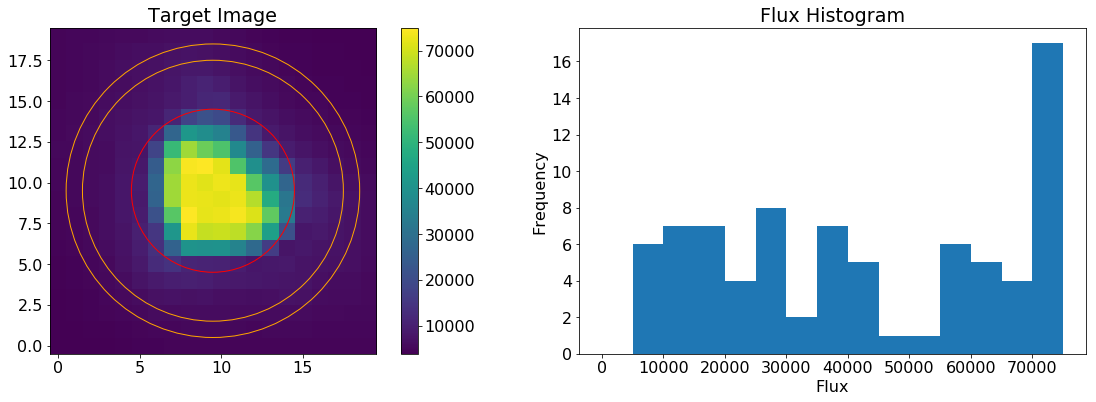

In [5]:

file = 1 # **specify target file number to display target image**

size = 20 # **specify pixel size of target image**
center = len(data[file-1])/2 # calculate center location of target image
target = data[file-1][int(center-size/2):int(center+size/2),int(center-size/2):int(center+size/2)] # create array of target image data values for specified file


# **specify target star aperture and background annulus center coordinates and radii for target image**

aperture = circle((9.5,9.5), r=5)
background = annulus((9.5,9.5), r_in=8, r_out=9) 


# create target image with target aperture and background annulus

plt.subplot(121)
plt.title('Target Image')
plt.imshow(target, origin='lower')
plt.colorbar()
aperture.plot(color='red')
background.plot(color='orange')


aperture_mask = aperture.to_mask(method='center') # create mask over pixels in target aperture that have their centers within the annulus 
aperture_data = aperture_mask[0].multiply(target) # create array of flux values with zero values corresponding to data outside the mask and nonzero values corresponding to the data within the mask 
aperture_flux = aperture_data[aperture_mask[0].data > 0] # create array of flux values contained in mask

bin_size = 5000 # **specify bin size for histogram**
bins = np.arange(0,max(np.ndarray.flatten(target)+bin_size),bin_size) # create bins for histogram up to highest flux value in aperture


# create flux histrogram of values within target aperture

plt.subplot(122)
plt.hist(aperture_flux, bins);
plt.title('Flux Histogram')
plt.xlabel('Flux')
plt.ylabel('Frequency');
plt.show()

                                            Examining Abnormal Flux Values

In [6]:
surroundings_file_names = '/Users/chris/Documents/KELT/Y Oph-Surrounding Area Image Cutouts/Image_%04d.txt' # **specify path of file names for surrounding area image cutouts**
all_surroundings_files = [surroundings_file_names % i for i in range(1,files+1)] # create file path names for all surrounding area cutouts
surroundings_data = [np.loadtxt(all_surroundings_files[i], dtype='float') for i in range(0,files)]  # get data from surrounding area cutouts

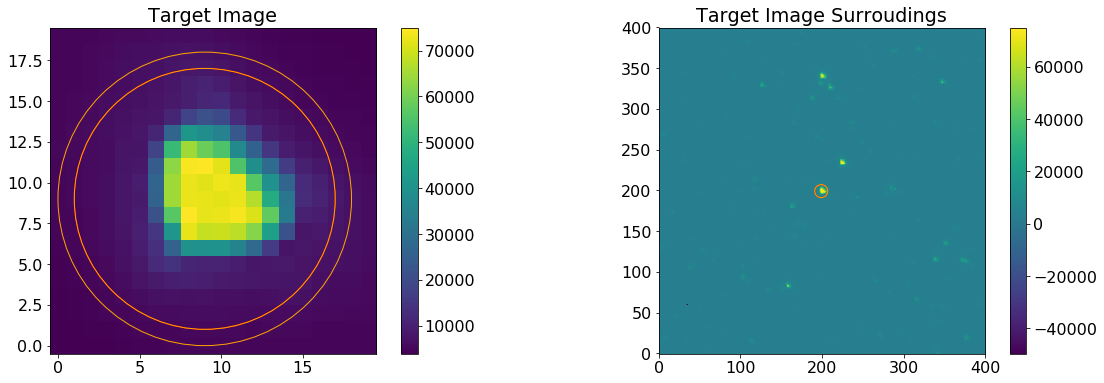

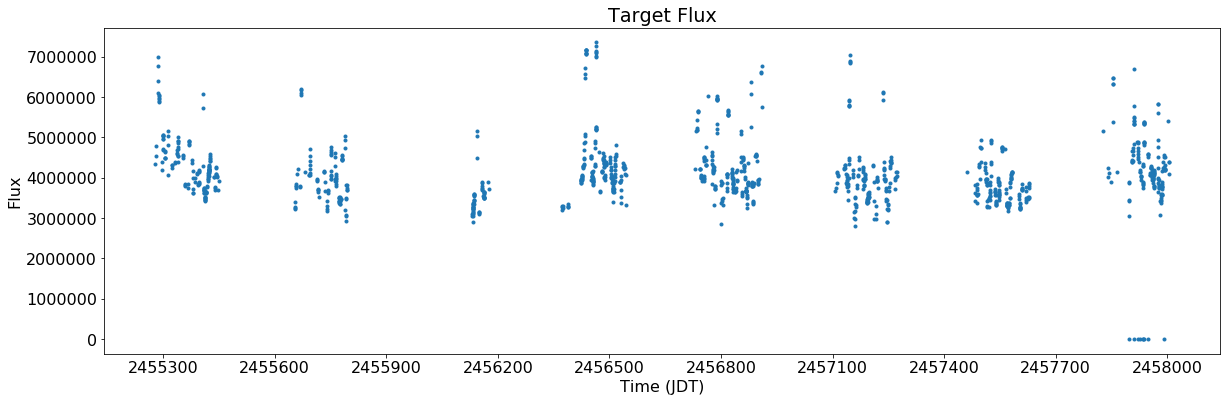

Low Flux Values

File    Target Flux
999        0.0
1020        0.0
1031        0.0
1034        0.0
1048        0.0
1051        0.0
1057        0.0
1064        0.0
1142        0.0



High Flux Values

File    Target Flux


In [7]:

file = 1 # **specify target file number to display target image**

size = 20 # **specify pixel size of target image**
center = len(surroundings_data[file-1])/2 # calculate center location of target image
target = surroundings_data[file-1][int(center-size/2):int(center+size/2),int(center-size/2):int(center+size/2)] # create array of target image data values for specified file

x_a = 9 # **specify x coordinate of target aperture center**
y_a = 9 # **specify y coordinate of target aperture center**
r = 8 # **specify radius of target aperture**

x_b = 9 # **specify x coordinate of background annulus center**
y_b = 9 # **specify y coordinate of background annulus center**
r_in = 8 # **specify inner radius of background annulus**
r_out = 9 # **specify outer radius of background annulus**

aperture = circle((x_a,y_a), r) # create circular aperture around target by specifying its center coordinates and radius
background = annulus((x_b,y_b), r_in, r_out) # create annulus for background flux by specifying its center coordinates, inner radius, and outer radius


# create target image with target aperture and background annulus

mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['font.size'] = 16

plt.subplot(121)
plt.title('Target Image')
plt.imshow(target, origin='lower')
plt.colorbar()
aperture.plot(color='red')
background.plot(color='orange')


target_data = [surroundings_data[i][int(center-size/2):int(center+size/2),int(center-size/2):int(center+size/2)] for i in range(0,files)] # create array of target image data values for all files
target_sum = [photometry(target_data[i], aperture, method = 'exact') for i in range(0,files)] # sum up exact amount of flux contained in the target aperture
target_flux = np.array([target_sum[i]['aperture_sum'] for i in range (0,files)]) # get flux of target aperture without disregarding zero flux values

offset = (len(surroundings_data[file-1])-size)/2 # calculate difference between center coordinates of target image and surrounding area image
aperture = circle((x_a+offset,y_a+offset), r) # place aperture on target star in surrounding area image
background = annulus((x_b+offset,y_b+offset), r_in, r_out) # place background annulus so that it is surrounding target star in surrounding area image


# create surrounding area image with target aperture and background annulus

plt.subplot(122)
plt.title('Target Image Surroudings')
plt.imshow(surroundings_data[file-1], origin='lower')
plt.colorbar() 
aperture.plot(color='red') 
aperture.plot(color='orange')
plt.show()

time = [open_files[i][1].header['JDT'] for i in range(0,len(target_flux))] # get time values for target image data


# create light curve for target flux with zero flux values

plt.title('Target Flux')
plt.xlabel('Time (JDT)')
plt.ylabel('Flux')
plt.xticks(np.arange(round(min(time),-2), max(time)+1, round((max(time)+1-min(time))/10,-2)))
plt.plot(time, target_flux, '.')
plt.show()


low_flux = 1000000 # **specify lower limit for target flux values**
high_flux = np.inf # **specify upper limit for target flux values**


# print flux values and corresponding file number for values that fall outside specified limits

print("Low Flux Values")
print("")
print("File    Target Flux")
for i in range(0,len(target_flux[target_flux < low_flux])):
    print(np.add(np.where(target_flux < low_flux),1)[0][i], "      ", target_flux[target_flux < low_flux][i])
print("")
print("")
print("")
print("High Flux Values")
print("")
print("File    Target Flux")
for i in range(0,len(target_flux[target_flux > high_flux])):
    print(np.add(np.where(target_flux > high_flux),1)[0][i], "      ", target_flux[target_flux > high_flux][i])